# **Detection of Covid Positive Cases using Image Processing**

> Since COVID-19 attacks the epithelial cells that line our respiratory tract, we can use X-rays to analyze the health of a patient’s lungs.

<div style="width:100%;text-align: center;"> 
    <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/7/72/Projectional_rendering_of_CT_scan_of_thorax_%28thumbnail%29.gif" alt="Heat beating" style="height:400px;margin-top:3rem;"> 
</div>

# [Data Source](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Required Libraries 

In [ ]:
! pip install --upgrade albumentations

In [ ]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

# Reading The Data

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/"

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [ ]:
levels = ['Normal/images/', 'COVID/images/']
path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images/': 'Negative',
                                                   'COVID/images/': 'Positive'})
samples = 13808

data.head()

,image_file,corona_result,path
0,Normal/images//Normal-9269.png,Negative,/content/drive/MyDrive/Colab Notebooks/COVID-1...
1,Normal/images//Normal-9199.png,Negative,/content/drive/MyDrive/Colab Notebooks/COVID-1...
2,Normal/images//Normal-9246.png,Negative,/content/drive/MyDrive/Colab Notebooks/COVID-1...
3,Normal/images//Normal-8948.png,Negative,/content/drive/MyDrive/Colab Notebooks/COVID-1...
4,Normal/images//Normal-8945.png,Negative,/content/drive/MyDrive/Colab Notebooks/COVID-1...


In [ ]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


# Exploratory Data Analysis 

### 1. Count Plot 

In [ ]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

### 2. Image Samples

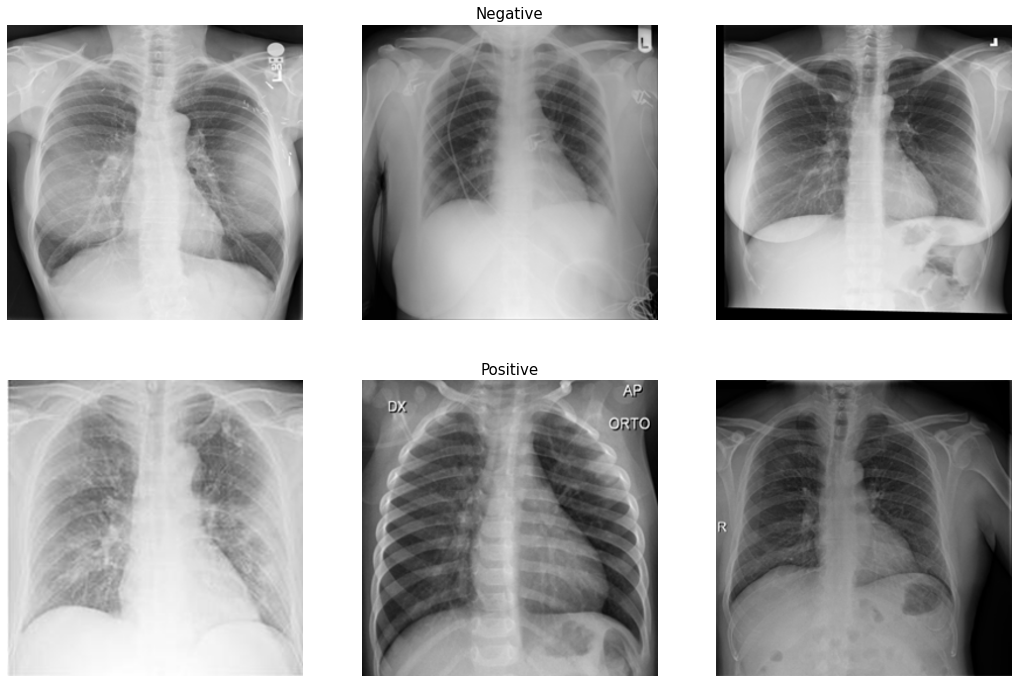

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

### 5. Ben Graham's Method

> First, we convert the images to greyscale and then apply Gaussian blur to them.

In [ ]:
all_covid = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "Normal/images/*.png")))
all_covid.extend(glob(os.path.join(path, "COVID/images/*.png")))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]

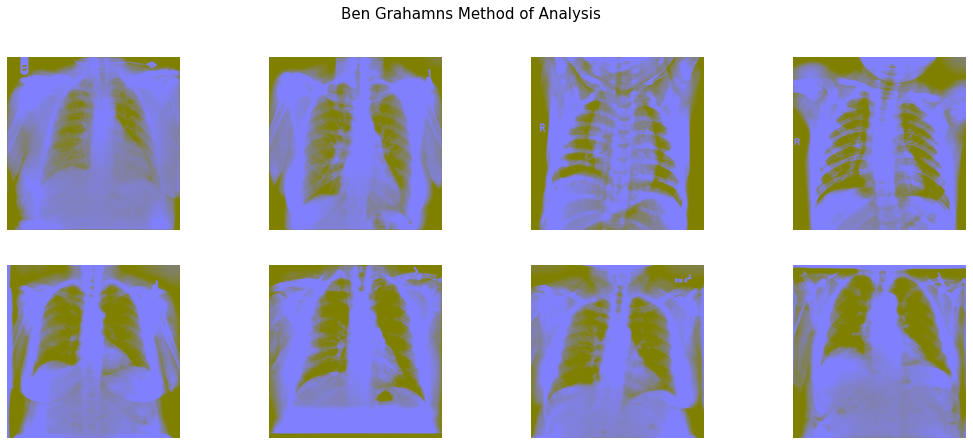

In [ ]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### 6. Albumentations Visualization

In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

# Data Modeling 

### Train Test Split 

In [ ]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [ ]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


### CNN Model

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

# cnn_model.add(layers.Dense(units = 2))
# cnn_model.compile(optimizer = 'adam', 
#            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
#            metrics = ['accuracy'])

cnn_model.add(layers.Dense(units = 1, activation='sigmoid'))
cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



39/39 [==============================] - 159s 4s/step - loss: 0.5854 - accuracy: 0.7210 - val_loss: 0.5372 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 156s 4s/step - loss: 0.5038 - accuracy: 0.7330 - val_loss: 0.4346 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 156s 4s/step - loss: 0.4648 - accuracy: 0.7330 - val_loss: 0.3860 - val_accuracy: 0.7638
Epoch 4/50
39/39 [==============================] - 155s 4s/step - loss: 0.4030 - accuracy: 0.8090 - val_loss: 0.3377 - val_accuracy: 0.8362
Epoch 5/50
39/39 [==============================] - 156s 4s/step - loss: 0.3624 - accuracy: 0.8509 - val_loss: 0.3161 - val_accuracy: 0.8615
Epoch 6/50
39/39 [==============================] - 153s 4s/step - loss: 0.3488 - accuracy: 0.8623 - val_loss: 0.3223 - val_accuracy: 0.8778
Epoch 7/50
39/39 [==============================] - 154s 4s/step - loss: 0.3296 - accuracy: 0.8700 - val_loss: 0.2895 - val_accuracy: 0.8814
Epoch 8/50
39/39 [======

In [ ]:
yp_train = cnn_model.predict(x_train)
# yp_train = np.argmax(yp_train, axis = 1)
yp_train = [1 if prob > 0.5 else 0 for prob in np.ravel(yp_train)]

yp_val = cnn_model.predict(x_val)
# yp_val = np.argmax(yp_val, axis = 1)
yp_val = [1 if prob > 0.5 else 0 for prob in np.ravel(yp_val)]

yp_test = cnn_model.predict(x_test)
# yp_test = np.argmax(yp_test, axis = 1)
yp_test = [1 if prob > 0.5 else 0 for prob in np.ravel(yp_test)]

### Model Evaluation

In [ ]:
predictions = cnn_model.predict(x_test)
prediction_classes = [1 if prob > 0.5 else 0 for prob in np.ravel(predictions)]

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction_classes))

from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.4f}')
print(f'Precision: {precision_score(y_test, prediction_classes):.4f}')
print(f'Recall: {recall_score(y_test, prediction_classes):.4f}')

[[2021   40]
 [  67  634]]
Accuracy: 0.9613
Precision: 0.9407
Recall: 0.9044


In [ ]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    print(cm_train)
    
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

[[7221   66]
 [  46 2608]]
Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7287
           1       0.98      0.98      0.98      2654

    accuracy                           0.99      9941
   macro avg       0.98      0.99      0.99      9941
weighted avg       0.99      0.99      0.99      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9827
Specificity on Train Data:  0.9909
Accuracy on Train Data:  0.9887
Precision on Train Data:  0.9753
F1 Score on Train Data:  0.979
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       844
           1       0.92      0.92      0.92       261

  

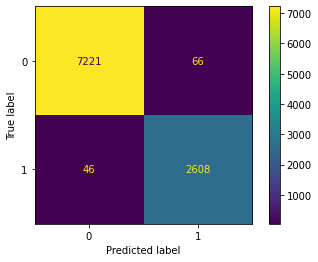

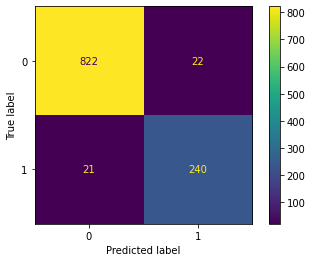

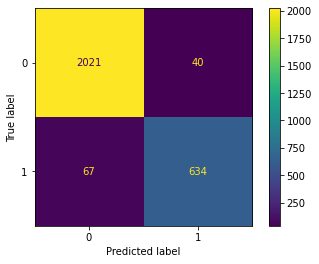

In [ ]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

In [ ]:
# list all data in history

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


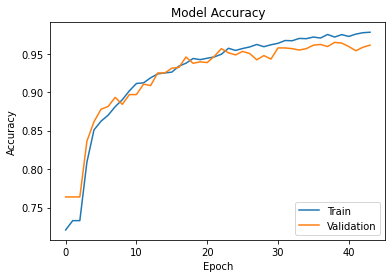

In [ ]:
# Summarize History for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

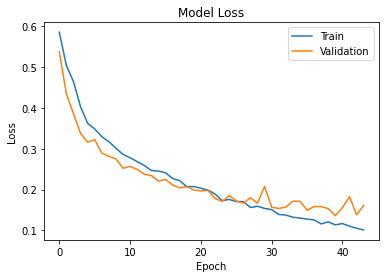

In [ ]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [ ]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

> We observe that Train & Validation Accuracy's Curve slightly overlap and same with Loss Curve. 

> Hence, Overfitting is avoided, this is possible because of Dropout Regularization & Early Stopping Metrics.

In [ ]:
for type_name, type_rows in data.sort_values(['corona_result']).groupby('corona_result'):
     for _, c_row in type_rows.sample(n_samples, random_state = 13).iterrows():       
        picture = c_row['path']
        # print(picture)
        image = cv2.imread(picture)
        z_img = cv2.resize(image, (70, 70)) / 255.0
        z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])

        z_prob = cnn_model.predict(z_img)
        z_class = [1 if prob > 0.5 else 0 for prob in np.ravel(z_prob)]

        z_class = z_class[0]
        z_prob = np.ravel(z_prob)[0]
        if z_class == 0:
            print(f"Image: {z_class}, with probability: {(1-z_prob)*100:.2f}%")
        else:
            print(f"Image: {z_class}, with probability: {z_prob*100:.2f}%")

### Checking with Model

In [ ]:
diagnosis = cnn_model.predict(z_img)[0][0]
probability_cov = diagnosis * 100
probability_no_cov = (1 - diagnosis) * 100

print(diagnosis, probability_cov, probability_no_cov)

0.8035829 80.35829067230225 19.641709327697754


# Saving Model

In [ ]:
cnn_model.save('cnn_model.h5')